# Dynamic Labor Supply: 2-Period Model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, NonlinearConstraint
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.") # turn of annoying warning

from consav.linear_interp import interp_1d

## Solution and Parameters

In [2]:
# per-period utility
def util(C,h,par):
    return (C**(1+par.eta))/(1+par.eta) - par.beta*(h**(1+par.gamma))/(1+par.gamma)

def cons_period2(h2,w2,N2,b,par):
    return (1.0-par.tau)*w2*h2 + N2 - (1+par.r)*b

def value_of_choice1(C1,h1,w1,N1,V2,par):
    
    # current period utility
    u1 = util(C1,h1,par)
    
    # implied borrowing
    b = -((1.0-par.tau)*w1*h1 + N1 - C1)
    
    # next-period value of this level of b
    V2_interp = interp_1d(par.b_grid,V2,b)
    
    # discounted value
    return u1 + par.rho*V2_interp

# solution
def solve(w1,w2,N1,N2,par):
    
    # last period
    V2 = np.nan + np.ones(par.b_grid.size)
    h2_vec = np.nan + np.ones(par.b_grid.size)
    h2_init = np.array([20.0])
    for ib,b in enumerate(par.b_grid):
        obj2 = lambda h: -util( cons_period2(h,w2,N2,b,par) , h,par)
        if ib>0: h2_init = np.array(h2_vec[ib-1])
        
        # constraints: ensure positive consumption
        bounds = ((0.0,200.0),)
        constr = lambda h: cons_period2(h,w2,N2,b,par) 
        nlc = NonlinearConstraint(constr, lb=0.0, ub=np.inf,keep_feasible=True)
        
        res = minimize(obj2,h2_init,bounds=bounds,constraints=nlc,method='trust-constr')
        h2_vec[ib] = res.x[0]
        V2[ib] = -res.fun
        
        
    # first period
    obj1 = lambda x: -value_of_choice1(x[0],x[1],w1,N1,V2,par)
    init = np.array([1.0,2.0])
    bounds = ((0.0001,2000.0),(0.0,2000.0))

    res = minimize(obj1,init,bounds=bounds,method='trust-constr')
    C1 = res.x[0]
    h1 = res.x[1]
    V1 = -res.fun
    
    return C1,h1,h2_vec

In [3]:
# parameters 
class par: pass
par.beta = 0.1
par.eta = -2.0
par.gamma = 2.5
par.tau = 0.1
par.r = 0.02
par.rho = 1/(1+par.r)

# grid of wealth
par.b_grid = np.linspace(-5.0,5.0,100)

## Solve model

In [4]:
# find optimal labor supply for a given level of wages and non-labor income
w1 = 1.0
w2 = 1.0
N1 = 0.0 # non-labor income. Important for strength of income effect
N2 = 0.0 # non-labor income. Important for strength of income effect
C1,h1,h2_vec = solve(w1,w2,N1,N2,par)

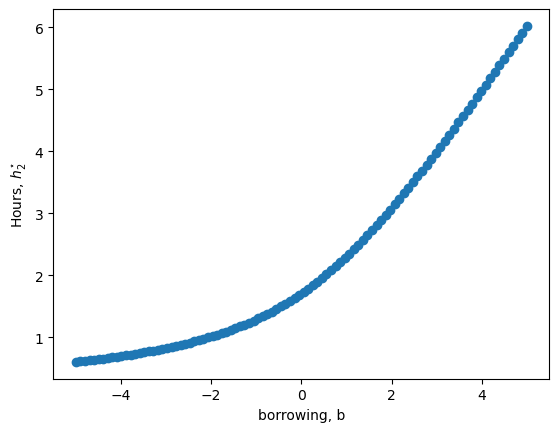

In [5]:
fig, ax = plt.subplots()
ax.scatter(par.b_grid,h2_vec)
ax.set(xlabel='borrowing, b',ylabel='Hours, $h^{\star}_2$');

**Question 1:** Does the last-period optimal hours worked as a function of borrowing have an intuitive slope?

**Check consumption is constant**

In [13]:
# consumption should be rather constant across periods for this parametrization
b = -((1.0-par.tau)*w1*h1 + N1 - C1)
h2 = interp_1d(par.b_grid,h2_vec,b)
C2 = cons_period2(h2,w2,N2,b,par)
print(f'C1={C1:2.3f}, C2={C2:2.3f}')

C1=1.537, C2=1.537


## In-class exercise
1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Elasticities

**Marshall**

In [7]:
# Marshall elasticity
# theoretical (when rho=1/(1+r) and N1=N2=0)
ela_M = (1+par.eta) / (par.gamma - par.eta)

# simulate permanent increase
C1_,h1_1pct,h2_ = solve(w1*1.01,w2*1.01,N1,N2,par)
ela_M1_sim = (h1_1pct-h1)/h1*100

print(f'Marshall: {ela_M:2.3f}, Simulated: {ela_M1_sim:2.3f}')

Marshall: -0.222, Simulated: -0.221


**Frisch**

In [8]:
# Frisch elasticity
ela_F = 1/par.gamma

# simulate transitory increase in first period
C1_,h1_F,h2_ = solve(w1*1.01,w2,N1,N2,par)
ela_F1_sim = (h1_F-h1)/h1*100

print(f'Frisch: {ela_F:2.3f}, Simulated: {ela_F1_sim:2.3f}')

Frisch: 0.400, Simulated: 0.399


## In-Class Exercise
Include a 10 pct. risk of dying in period two with an associated value of zero. Compare the Frisch elasticity with the original one. Interpret the difference.

In [16]:
# WRITE YOUR CODE HERE
def value_of_choice1_new(C1,h1,w1,N1,V2,par):
    
    # current period utility
    u1 = util(C1,h1,par)
    
    # implied borrowing
    b = -((1.0-par.tau)*w1*h1 + N1 - C1)
    
    # next-period value of this level of b
    V2_interp = interp_1d(par.b_grid,V2,b)
    
    # discounted value
    return u1 + par.rho*(1-par.death)*V2_interp

# solution
def solve_new(w1,w2,N1,N2,par):
    
    # last period
    V2 = np.nan + np.ones(par.b_grid.size)
    h2_vec = np.nan + np.ones(par.b_grid.size)
    h2_init = np.array([20.0])
    for ib,b in enumerate(par.b_grid):
        obj2 = lambda h: -util( cons_period2(h,w2,N2,b,par) , h,par)
        if ib>0: h2_init = np.array(h2_vec[ib-1])
        
        # constraints: ensure positive consumption
        bounds = ((0.0,200.0),)
        constr = lambda h: cons_period2(h,w2,N2,b,par) 
        nlc = NonlinearConstraint(constr, lb=0.0, ub=np.inf,keep_feasible=True)
        
        res = minimize(obj2,h2_init,bounds=bounds,constraints=nlc,method='trust-constr')
        h2_vec[ib] = res.x[0]
        V2[ib] = -res.fun
        
        
    # first period
    obj1 = lambda x: -value_of_choice1_new(x[0],x[1],w1,N1,V2,par)
    init = np.array([1.0,2.0])
    bounds = ((0.0001,2000.0),(0.0,2000.0))

    res = minimize(obj1,init,bounds=bounds,method='trust-constr')
    C1 = res.x[0]
    h1 = res.x[1]
    V1 = -res.fun
    
    return C1,h1,h2_vec

In [29]:
#Solve new model
par.death=0.1

C1,h1,h2_vec = solve_new(w1,w2,N1,N2,par)

# simulate transitory increase in first period
C1_,h1_F,h2_ = solve_new(w1*1.01,w2,N1,N2,par)
ela_F1_sim = (h1_F-h1)/h1*100

print(f'Frisch: {ela_F:2.3f}, Simulated: {ela_F1_sim:2.3f}')


Frisch: 0.400, Simulated: -0.514


## solution

In [10]:
# solution
def value_of_choice1_death(C1,h1,w1,N1,V2,par):
    
    # current period utility
    u1 = util(C1,h1,par)
    
    # implied borrowing
    b = -((1.0-par.tau)*w1*h1 + N1 - C1)
    
    # next-period value of this level of b and alive
    V2_alive = interp_1d(par.b_grid,V2,b)
    
    # value if dead
    V2_death = 0.0
    
    # expected value
    EV2 = par.prob_death*V2_death + (1-par.prob_death)*V2_alive
    
    # discounted value
    return u1 + par.rho*EV2

def solve_death(w1,w2,N1,N2,par):
    
    # last period
    V2 = np.nan + np.ones(par.b_grid.size)
    h2_vec = np.nan + np.ones(par.b_grid.size)
    h2_init = np.array([20.0])
    for ib,b in enumerate(par.b_grid):
        obj2 = lambda h: -util( cons_period2(h,w2,N2,b,par) , h,par)
        if ib>0: h2_init = np.array(h2_vec[ib-1])
        
        # constraints: ensure positive consumption
        bounds = ((0.0,200.0),)
        constr = lambda h: cons_period2(h,w2,N2,b,par) 
        nlc = NonlinearConstraint(constr, lb=0.0, ub=np.inf,keep_feasible=True)
        
        res = minimize(obj2,h2_init,bounds=bounds,constraints=nlc,method='trust-constr')
        h2_vec[ib] = res.x[0]
        V2[ib] = -res.fun
        
        
    # first period
    obj1 = lambda x: -value_of_choice1_death(x[0],x[1],w1,N1,V2,par)
    init = np.array([1.0,2.0])
    bounds = ((0.0001,2000.0),(0.0,2000.0))

    res = minimize(obj1,init,bounds=bounds,method='trust-constr')
    C1 = res.x[0]
    h1 = res.x[1]
    V1 = -res.fun
    
    return C1,h1,h2_vec

In [24]:
# solve
par.prob_death = 0.1
C1_death,h1_death,h2_vec_death = solve_death(w1,w2,N1,N2,par)

In [25]:
# Frisch elasticity
# simulate transitory increase in first period
_,h1_death_F,_ = solve_death(w1*1.01,w2,N1,N2,par)
ela_F1_death = (h1_death_F-h1_death)/h1_death*100

print(f'Old Frisch: {ela_F:2.3f}, New, with death: {ela_F1_death:2.3f}')

Old Frisch: 0.400, New, with death: 0.080
